In [97]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import shutil
import torch
import json
from study_alignment.standardize import fill_na_by_cohort, standardize_across_cohorts

In [175]:
data_dir = '/Users/jonaheaton/Desktop/newcastle_nash_study_feb20'

input_dir = os.path.join(data_dir, 'alignment_1')
cohort_ids = pd.read_csv(os.path.join(input_dir,'combined_study_cohort_ids.csv'), index_col=0)
combined_study = pd.read_csv(os.path.join(input_dir, 'combined_study.csv'), index_col=0)
nan_mask = pd.read_csv(os.path.join(input_dir,'combined_study_nan_mask.csv'), index_col=0)
cohort_ids.set_index('file_name', inplace=True)

alignment_df = pd.read_csv(os.path.join(input_dir, 'alignment_df.csv'), index_col=0)


In [176]:
alignment_df.dropna().shape

(42, 4)

In [166]:
freq_count = 1 - nan_mask.sum()/nan_mask.shape[0]
print(freq_count.min(), freq_count.max())

0.053608247422680444 0.9463917525773196


In [167]:
metadata = pd.read_csv(os.path.join(data_dir, 'newcastle_metadata.tsv'), index_col=0, sep='\t')
finetune_col = 'fibro_binary'
metadata.dropna(subset=[finetune_col], inplace=True)
metadata.index = [x+'.mzdata.mzML' for x in metadata.index]

In [168]:
ref_freqs = 1- nan_mask[metadata.index].sum()/nan_mask.shape[0]
print(ref_freqs.min(), ref_freqs.max())

0.3278350515463917 0.9463917525773196


In [169]:
ref_freqs = 1- nan_mask[metadata.index].sum(axis=1)/nan_mask.shape[1]
print(ref_freqs.min(), ref_freqs.max())

0.7493188010899183 1.0


In [170]:
metadata['fibro_binary'].isna().sum()

0

In [171]:
metadata['fibro_binary'].value_counts()

fibro_binary
low     430
high    178
Name: count, dtype: int64

In [172]:
combined_study = combined_study[cohort_ids.index.to_list()]
cohort_id_list = cohort_ids['mzlearn_cohort_id'].to_list()

In [173]:
combined_study[nan_mask] = np.nan
combined_study = fill_na_by_cohort(combined_study, cohort_id_list, method= 'mean_1th')
data_corrected = standardize_across_cohorts(combined_study, cohort_id_list, method='zscore')

fill missing values with the sample mean


In [174]:
cohort_ids['mzlearn_cohort_id'].nunique()

6

In [152]:
data_corrected.shape

(850, 1133)

In [153]:
cols_finetune  = metadata.index.to_list()
X_finetune_file = 'X_finetune.csv'
y_finetune_file = 'y_finetune.csv'
X_pretrain_file = 'X_pretrain.csv'
cols_pretrain = [x for x in data_corrected.columns if x not in cols_finetune]

if not os.path.exists(input_dir+'/y_finetune.csv'):
    data_corrected[cols_pretrain].T.to_csv(os.path.join(input_dir, X_pretrain_file))
    data_corrected[cols_finetune].T.to_csv(os.path.join(input_dir, X_finetune_file))
    metadata.loc[cols_finetune].to_csv(os.path.join(input_dir, y_finetune_file))

In [154]:
print('number of pretraining files:', len(cols_pretrain))
print('number of finetuning files:', len(cols_finetune))
print('number of studies in pretrianing:', cohort_ids['mzlearn_cohort_id'].nunique())
print('number of features: ', data_corrected.shape[0])


number of pretraining files: 525
number of finetuning files: 608
number of studies in pretrianing: 5
number of features:  850


In [155]:
n_repeats = 2
cv_splits = 5
cross_val_seed = 42
y_stratify_col = 'fibro_binary'

save_dir = os.path.join(input_dir, 'results')
if not os.path.exists(save_dir):
    os.makedirs(save_dir, exist_ok=True)

    # save the pretraining data to the save_dir
    X_pretrain = pd.read_csv(os.path.join(input_dir, X_pretrain_file), index_col=0)
    X_pretrain.to_csv(os.path.join(save_dir, 'X_pretrain.csv'))
    shutil.copy(os.path.join(input_dir, X_pretrain_file), os.path.join(save_dir, 'X_pretrain.csv'))

    X_finetune = pd.read_csv(os.path.join(input_dir, X_finetune_file), index_col=0)
    y_finetune = pd.read_csv(os.path.join(input_dir, y_finetune_file), index_col=0)
    y_stratify = y_finetune[y_stratify_col]





    for iter in range(n_repeats):
        skf = StratifiedKFold(n_splits=cv_splits, random_state=cross_val_seed+iter, shuffle=True)
        skf.get_n_splits(X_finetune, y_stratify)

        # create a subdirectory for each of the cross-validation splits
        for i, (train_index, test_index) in enumerate(skf.split(X_finetune, y_stratify)):

            subset_id = iter * cv_splits + i
            X_train, X_val = X_finetune.iloc[train_index], X_finetune.iloc[test_index]
            y_train, y_val = y_finetune.iloc[train_index], y_finetune.iloc[test_index]
            X_train.to_csv(os.path.join(save_dir, f'X_train_{subset_id}.csv'))
            X_val.to_csv(os.path.join(save_dir, f'X_test_{subset_id}.csv'))
            y_train.to_csv(os.path.join(save_dir, f'y_train_{subset_id}.csv'))
            y_val.to_csv(os.path.join(save_dir, f'y_test_{subset_id}.csv'))

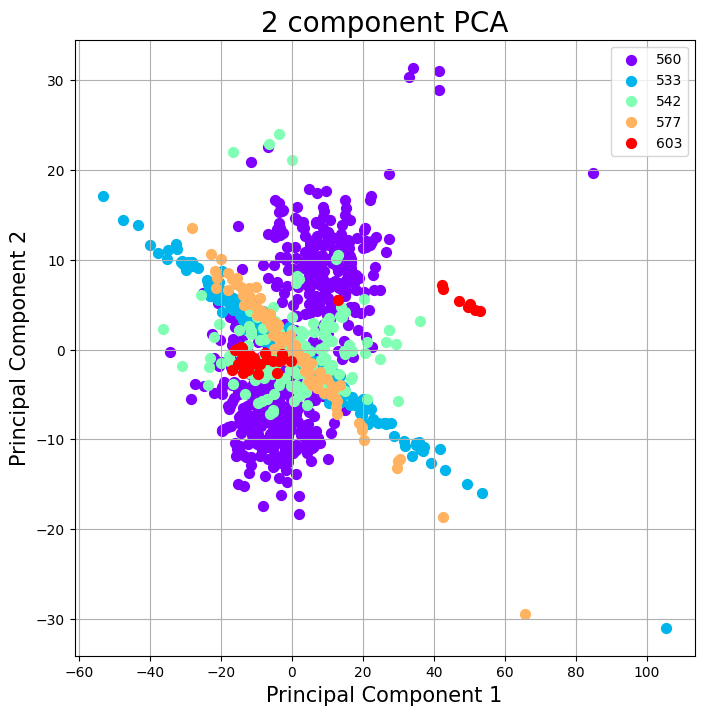

In [156]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the data
# scaler = StandardScaler()
# data_std = scaler.fit_transform(data_corrected.T)
data_std = data_corrected.T

# Perform PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(data_std)

# Create a DataFrame with the principal components
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

# Add the cohort id to the DataFrame
principalDf['cohort_id'] = cohort_ids['mzlearn_cohort_id'].values

# Plot the data
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

# Color by cohort id
colors = plt.cm.rainbow(np.linspace(0, 1, len(principalDf['cohort_id'].unique())))
for cohort_id, color in zip(principalDf['cohort_id'].unique(), colors):
    indicesToKeep = principalDf['cohort_id'] == cohort_id
    ax.scatter(principalDf.loc[indicesToKeep, 'principal component 1']
               , principalDf.loc[indicesToKeep, 'principal component 2']
               , c = [color]
               , s = 50)
ax.legend(principalDf['cohort_id'].unique())
ax.grid()


In [157]:
# import umap.umap_ as umap
# import matplotlib.pyplot as plt

# # Create a UMAP instance
# reducer = umap.UMAP()

# # Fit and transform the data
# embedding = reducer.fit_transform(data_corrected.T)

# # Create a scatter plot
# plt.figure(figsize=(10, 10))
# plt.scatter(embedding[:, 0], embedding[:, 1], c=cohort_id_list, cmap='Spectral')
# plt.gca().set_aspect('equal', 'datalim')
# plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
# plt.title('UMAP projection of the corrected data', fontsize=24)
# plt.show()


In [160]:
# file1 = '/Users/jonaheaton/Desktop/bidmc_nash_study_feb20/mzlearn_pretraining_peak_combine_results_27_merge_reference_freq_th_0.6_freq_th_0.2_alignment_df.csv'
file1 = '/Users/jonaheaton/Desktop/bidmc_nash_study_feb20/mzlearn_pretraining_peak_combine_results_27_merge_reference_freq_th_0.6_freq_th_0.2_combined_study.csv'
df1 = pd.read_csv(file1, index_col=0)

In [161]:
df1

,UM501.mzML,UM405.mzML,UM486.mzML,QC_pool_1x_01_20191225022918.mzML,UM518.mzML,UM462.mzML,UM496.mzML,QC_Pool_4.mzML,UM546.mzML,UM497.mzML,...,20160831_TP_CS00000001-6_P-20160831_CS00000001-6.mzML,20160831_PP_CS00000004-5_P-20160831_CS00000004-5.mzML,20160831_S00025127_P.mzML,20160831_TP_CS00000001-4_P-20160831_CS00000001-4.mzML,20160831_S00025126_P.mzML,20160831_SM_CS00000003-3_P-20160831_CS00000003-3.mzML,20160831_SM_CS00000003-1_P-20160831_CS00000003-1.mzML,20160831_S00025120_P.mzML,20160831_S00025125_P.mzML,20160831_S00025118_P.mzML
FT1029,17.896587,17.280543,17.872969,17.814832,17.807142,17.850690,17.859044,17.677010,17.771032,17.290635,...,12.111984,12.371315,12.249025,12.131089,11.980528,11.256086,11.256086,12.302887,12.248850,12.277800
FT105,14.859787,11.935090,13.684436,13.317477,11.935090,15.841738,15.520821,13.741419,11.935090,15.679163,...,13.340013,13.594350,13.446014,13.325330,13.242314,13.556372,13.405595,13.376798,13.451504,13.393886
FT1113,15.009785,14.252631,15.289794,15.309510,15.596035,13.580249,15.626633,15.241150,15.735260,16.049128,...,9.663994,9.663994,9.663994,9.663994,9.690610,9.663994,12.961693,9.663994,9.663994,9.663994
FT1123,16.582018,15.844792,16.712362,16.945738,17.206438,16.542830,17.269740,16.793885,17.226202,17.625847,...,10.513739,11.508678,11.177673,10.932544,10.961817,14.354923,14.157138,10.986026,10.513739,11.152308
FT1154,14.281472,14.887290,14.281472,15.513124,14.281472,15.970812,14.681972,15.408643,16.878190,16.322011,...,14.479720,14.435762,14.497693,14.374869,14.170059,14.089685,14.089685,14.108925,14.555147,14.270014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FT879,16.385050,16.213981,16.773162,16.799500,16.971469,16.648522,15.707445,16.606574,16.918706,16.200998,...,11.483847,11.534248,11.626164,11.222410,11.849439,10.495688,10.495688,11.884635,11.756205,11.330749
FT894,13.947995,15.218448,16.654886,16.411184,14.926329,17.983146,15.943954,15.999799,18.070293,18.087713,...,8.586910,8.586910,9.471170,8.586910,8.586910,8.586910,8.586910,8.586910,10.757786,10.632836
FT895,15.754476,15.475902,16.396522,16.412228,16.601241,16.054535,16.126206,16.275828,16.598059,16.594450,...,11.106114,11.739891,11.819428,10.381225,10.381225,14.237088,14.081579,10.381225,11.182801,10.381225
FT926,19.800011,19.410278,20.512426,20.540816,20.688196,20.115715,20.240123,20.452376,20.831297,20.629526,...,12.067668,12.129410,12.323085,11.797672,11.951590,14.877111,14.421515,11.790360,12.445720,11.671448


In [162]:
file2 = '/Users/jonaheaton/Desktop/bidmc_nash_study_feb20/mzlearn_pretraining_peak_combine_results_27_merge_reference_freq_th_0.4_freq_th_0.1_combined_study.csv'

df2 = pd.read_csv(file2, index_col=0)

In [163]:
df2

,UM501.mzML,UM405.mzML,UM486.mzML,QC_pool_1x_01_20191225022918.mzML,UM518.mzML,UM462.mzML,UM496.mzML,QC_Pool_4.mzML,UM546.mzML,UM497.mzML,...,20160831_TP_CS00000001-6_P-20160831_CS00000001-6.mzML,20160831_PP_CS00000004-5_P-20160831_CS00000004-5.mzML,20160831_S00025127_P.mzML,20160831_TP_CS00000001-4_P-20160831_CS00000001-4.mzML,20160831_S00025126_P.mzML,20160831_SM_CS00000003-3_P-20160831_CS00000003-3.mzML,20160831_SM_CS00000003-1_P-20160831_CS00000003-1.mzML,20160831_S00025120_P.mzML,20160831_S00025125_P.mzML,20160831_S00025118_P.mzML
FT1049,13.508498,13.154366,13.154366,13.154366,13.154366,15.413633,13.154366,14.982419,13.154366,13.154366,...,14.330195,14.554771,14.606037,14.477514,14.447462,14.201622,14.201622,14.201622,14.529953,14.462187
FT105,14.859787,11.935090,13.684436,13.317477,11.935090,15.841738,15.520821,13.741419,11.935090,15.679163,...,13.001009,13.242195,13.053561,12.988706,12.947924,13.190854,13.088618,13.020513,13.057741,13.032255
FT1083,13.938720,12.494650,12.494650,14.184063,14.455781,12.494650,14.933258,12.494650,16.439012,16.882785,...,9.603352,9.603352,10.337712,9.603352,10.017035,9.603352,10.988783,9.603352,9.603352,10.211955
FT1098,12.979184,15.412109,13.581442,13.983401,14.829538,13.517043,14.094122,14.355103,14.235533,15.102180,...,13.001009,13.242195,13.053561,12.988706,12.947924,13.190854,13.088618,13.020513,13.057741,13.032255
FT1111,14.500658,13.949159,13.855105,14.808643,14.821577,14.823759,14.674786,14.664967,14.936842,15.289300,...,11.243867,10.185466,10.185466,11.181045,11.427484,10.185466,10.185466,10.185466,11.202744,11.178973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FT906,13.173856,13.173856,14.577371,13.173856,14.713438,13.173856,13.173856,13.173856,15.137348,14.804344,...,8.684442,8.684442,8.684442,9.536749,9.222288,8.684442,8.684442,8.684442,8.684442,8.684442
FT92,14.491407,15.058921,14.671263,15.705065,14.644752,16.194544,15.296318,15.353906,15.425141,15.496497,...,13.001009,13.242195,13.053561,12.988706,12.947924,13.190854,13.088618,13.020513,13.057741,13.032255
FT926,19.800011,19.410278,20.512426,20.540816,20.688196,20.115715,20.240123,20.452376,20.831297,20.629526,...,13.001009,13.242195,13.053561,12.988706,12.947924,13.190854,13.088618,13.020513,13.057741,13.032255
FT954,17.921197,17.577095,18.700657,18.720461,18.923900,18.174739,18.326095,18.624894,19.053303,18.774677,...,10.383603,10.383603,10.383603,10.383603,10.437073,10.383603,10.383603,10.408460,10.383603,10.383603
